Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Anamarija Hauptman"
COLLABORATORS = None

import numpy as np
import matplotlib.pyplot as plt
#import rvlib as rv
#import renderSurface

---

# Domača naloga 5: Geometrijske preslikave in poravnava oblik

1. Izvedite poravnavo vseh 2D oblik `[1, 29]` v datoteki `data/letala.npy` na obliko z indeksom 0 z metodo iterativno najbližje točke. Izrišite v eno sliko vse 2D oblike v začetni legi, v drugo sliko pa vse oblike v poravnani legi. 

 Za vsako poravnavo izračunajte napako pred poravnavo in po njej. V eno sliko narišite histogram vseh napak v začetni legi, v drugo sliko pa histogram napak v poravnani legi. Izpišite vrednost napake in indeks oblike, pri kateri dobite največjo in najmanjšo napako v začetni legi. Obliki tudi izrišite, zraven pa z drugo barvo dorišite še referenčno obliko. Enako naredite tudi za oblike po poravnavi.

1. 1. Prikažite grafa originalnih in poravnanih oblik:

In [21]:
deg2rad = lambda a: a*np.pi/180

def transAffine2D(iScale=(1, 1), iTrans=(0, 0), iRot=0, iShear=(0, 0)):
    iRot = deg2rad(iRot)
    oMatScale = np.array([[iScale[0],         0, 0],
                          [        0, iScale[1], 0],
                          [        0,         0, 1]])
    oMatTrans = np.array([[1, 0, iTrans[0]],
                          [0, 1, iTrans[1]],
                          [0, 0,         1]])
    oMatRot = np.array([[np.cos(iRot), -np.sin(iRot), 0],
                        [np.sin(iRot),  np.cos(iRot), 0],
                        [           0,             0, 1]])
    oMatShear = np.array([[        1, iShear[0], 0],
                          [iShear[1],         1, 0],
                          [        0,         0, 1]])
    oMat2D = np.dot(oMatTrans, np.dot(oMatShear, np.dot(oMatRot, oMatScale)))
    return oMat2D

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def mapAffineApprox2D(iPtsRef, iPtsMov): # referencne = U
    """Afina aproksimacijska poravnava"""
    # U = TX
    # UX'(XX')^(-1) = T
    iPtsRef = np.matrix(iPtsRef) # U
    iPtsMov = np.matrix(iPtsMov) # X
    # po potrebi dodaj homogeno koordinato
    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)
    #afina aproksimacia (s psevdoinvrzom XX')
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()
    #psevdoinverz
    oMat2D = np.dot(iPtsRef, np.linalg.pinv(iPtsMov))
    #oMat2D = iPtsRef*iPtsMov.transpose() * np.linalg.inv(iPts......)
    # Lahko uporabljamo *, ker imamo matrike. Če bi imeli array bi morali uporabljati np.dot 
    return oMat2D 

def findCorrespondingPoints(iPtsRef, iPtsMov):
    """Poisci korespondence kot najblizje tocke"""
    # inicializiraj polje indeksov
    iPtsMov = np.array(iPtsMov)
    iPtsRef = np.array(iPtsRef)
    
    idxPair = -np.ones((iPtsRef.shape[0],1), dtype='int32')
    idxDist = np.ones((iPtsRef.shape[0], iPtsMov.shape[0])) # za shranjevanje razdalij
    
    for i in range(iPtsRef.shape[0]):
        for j in range(iPtsMov.shape[0]):
            idxDist[i, j] = np.sum((iPtsRef[i, :2] - iPtsMov[j, :2])**2)
    # doloci bijektivno preslikavo
    while not np.all(idxDist == np.inf):
        i, j = np.where(idxDist == np.min(idxDist))
        idxPair[i[0]] = j[0]
        idxDist[i[0], :] = np.inf # nasli smo match in smo dali vse ostale pare, ki vsebuje eno od teh tock na Inf
        idxDist[:, j[0]] = np.inf
    # doloci pare tock
    idxValid, idxNotValid = np.where(idxPair >= 0)
    idxValid = np.array(idxValid)
    iPtsRef_t = iPtsRef[idxValid, :]
    iPtsMov_t = iPtsMov[idxPair[idxValid].flatten(), :]
    return iPtsRef_t, iPtsMov_t

def alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False):
    """Postopek iterativno najblizje tocke"""
    # inicializiraj izhodne parametre
    curMat = [] # seznam za shranjevanje matrik na vsakem koraku
    oErr = []
    iCurIter = 0
    if plotProgress:
        iPtsMov0 = np.matrix(iPtsMov)
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    #zacni iterativni postopek
    while True:
        #poisci korespondencn tocke
        iPtsRef_t, iPtsMov_t = findCorrespondingPoints(iPtsRef, iPtsMov)
        #doloci afino aproskimacijsko preslkavo 
        oMat2D = mapAffineApprox2D(iPtsRef_t, iPtsMov_t)
        #pososdobi posamezne tocke
        iPtsMov = np.dot(addHomCoord2D(iPtsMov), oMat2D.transpose())
        # izracunaj napako
        curMat.append(oMat2D)
        oErr.append(np.sqrt(np.sum((iPtsRef_t[:, :2] - iPtsMov_t[:, :2])**2)))
        iCurIter +=1
        # preveri kontroln parametre
        dMat = np.abs(oMat2D - transAffine2D())
        if iCurIter > iMaxIter or np.all(dMat < iEps):
            break
    # doloci kompozitum preslikav
    oMat2D = transAffine2D()
    for i in range(len(curMat)):
        if plotProgress:
            iPtsMov_t = np.dot(addHomCoord2D(iPtsMov0), oMat2D.transpose())
            ax.clear()
            ax.plot(iPtsRef[:, 0], iPtsRef[:, 1], 'ob')
            ax.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1], 'om')
            fig.canvas.draw()
            plt.pause(1)
        oMat2D = np.dot(curMat[i], oMat2D)
    return oMat2D, oErr

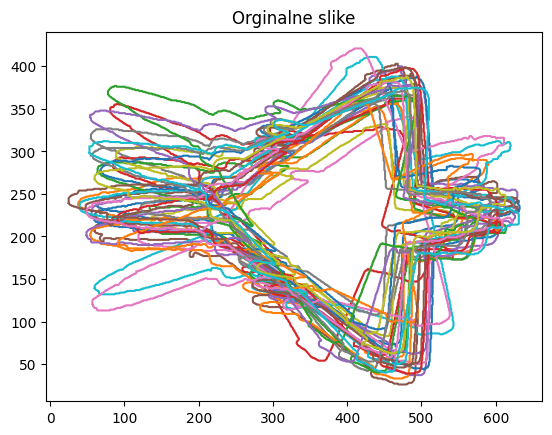

In [3]:
letala = np.load('data/letala.npy', allow_pickle=True)

plt.figure()
for n in range(30):
    plt.plot(letala[n][:, 0], letala[n][:, 1])
plt.title('Orginalne slike')
plt.show()

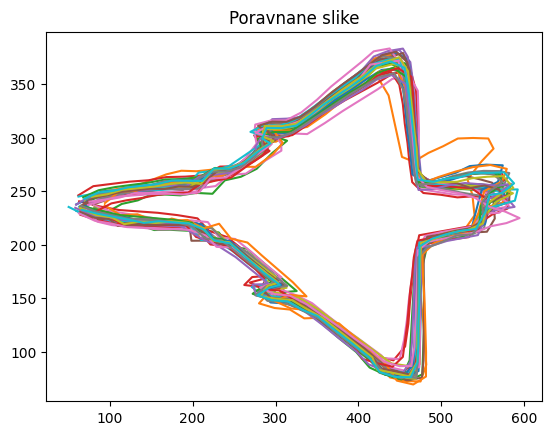

In [5]:
letala = np.load('data/letala.npy', allow_pickle=True)
step = 20
let = np.array(letala[0], dtype='float')
iPtsRef = let[::step]
err_1 = []
err_2 = []

plt.figure()
plt.plot(iPtsRef[:, 0], iPtsRef[:, 1])
for n in range(29):
    let = np.array(letala[n+1], dtype='float')
    iPtsMov = let[::step]
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False)
    err_1.append(oErr[0])
    err_2.append(oErr[-1])
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMov), oMat2D_t.transpose())   
    plt.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1])
plt.title('Poravnane slike')
plt.show()

1. 2. Za vsako poravnano sliko izračunajte napako pred poravnavo in po njej. Narišite histogram vseh napak v začetni legi in histogram napak v poravnani legi.

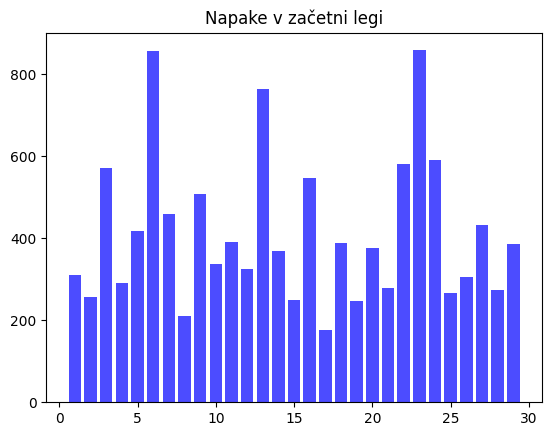

In [7]:
indexes = list(range(1, len(err_1) + 1))
plt.bar(indexes, err_1, color='b', alpha=0.7)
plt.title("Napake v začetni legi")
plt.show()

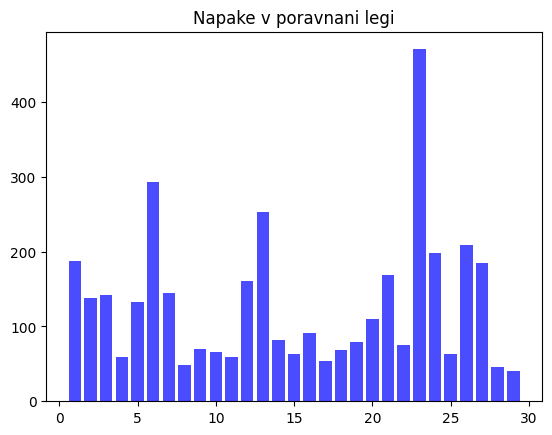

In [8]:
indexes = list(range(1, len(err_1) + 1))
plt.bar(indexes, err_2, color='b', alpha=0.7)
plt.title("Napake v poravnani legi")
plt.show()

1. 3. Izpišite vrednost napake in indeks oblike, pri kateri dobite največjo in najmanjšo napako v začetni legi. Obliki tudi izrišite, zraven pa z drugo barvo dorišite še referenčno obliko. Enako naredite tudi za oblike po poravnavi.

najmanjša napaka pred poravnavo: letala[17]: 177.14400921284354
največja napaka pred poravnavo: letala[23]: 858.8678594521976


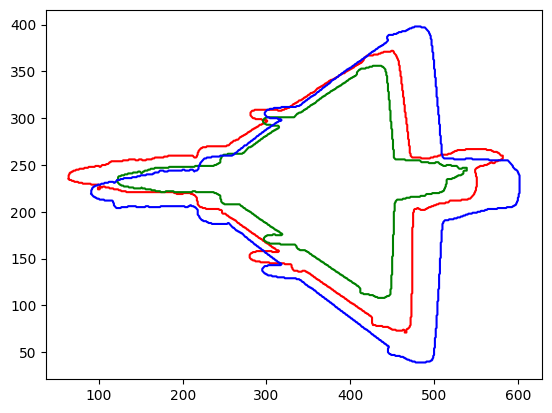

'\nrdeča ... referenčna oblika\nzelena ... oblika z najmanjšo napako pred poravnavo\nmodra ... oblika z največjo napako pred poravnavo\n'

In [13]:
min_1 = np.min(err_1)
max_1 = np.max(err_1)
id_min_1 = err_1.index(min_1) + 1
id_max_1 = err_1.index(max_1) + 1
print('najmanjša napaka pred poravnavo: letala[' + str(id_min_1) + ']: ' + str(min_1))
print('največja napaka pred poravnavo: letala[' + str(id_max_1) + ']: ' + str(max_1))

plt.figure()
plt.plot(letala[0][:, 0], letala[0][:, 1], 'r')
plt.plot(letala[id_min_1][:, 0], letala[id_min_1][:, 1], 'g')
plt.plot(letala[id_max_1][:, 0], letala[id_max_1][:, 1], 'b')
plt.show()

'''
rdeča ... referenčna oblika
zelena ... oblika z najmanjšo napako pred poravnavo
modra ... oblika z največjo napako pred poravnavo
'''

najmanjša napaka po poravnavi: letala[29]: 40.34702102222593
največja napaka po poravnavi: letala[23]: 470.28730877803196


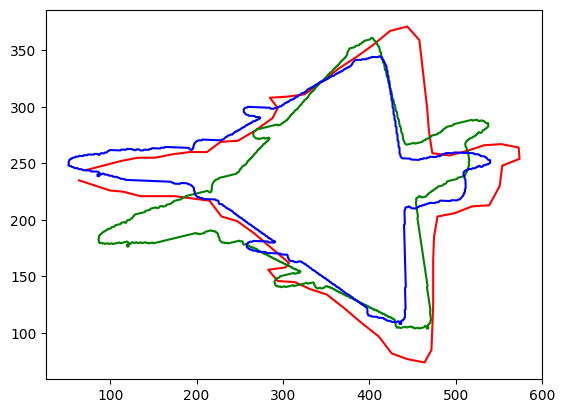

'\nrdeča ... referenčna oblika\nzelena ... oblika z najmanjšo napako po poravnavi\nmodra ... oblika z največjo napako po poravnavi\n'

In [14]:
min_2 = np.min(err_2)
max_2 = np.max(err_2)
id_min_2 = err_2.index(min_2) + 1
id_max_2 = err_2.index(max_2) + 1
print('najmanjša napaka po poravnavi: letala[' + str(id_min_2) + ']: ' + str(min_2))
print('največja napaka po poravnavi: letala[' + str(id_max_2) + ']: ' + str(max_2))

iPtsRef = letala[0][::step]
iPtsMov_min = letala[id_min_2][::step]
iPtsMov_max = letala[id_max_2][::step]
plt.figure()
plt.plot(iPtsRef[:, 0], iPtsRef[:, 1], 'r')
oMat2D_t, _ = alignICP(iPtsRef, iPtsMov_min, iEps=1e-6, iMaxIter=50, plotProgress=False)
iPtsMov_t = np.dot(addHomCoord2D(letala[0]), oMat2D_t.transpose())   
plt.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1], 'g')
oMat2D_t, _ = alignICP(iPtsRef, iPtsMov_max, iEps=1e-6, iMaxIter=50, plotProgress=False)
iPtsMov_t = np.dot(addHomCoord2D(letala[0]), oMat2D_t.transpose())   
plt.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1], 'b')
plt.show()

'''
rdeča ... referenčna oblika
zelena ... oblika z najmanjšo napako po poravnavi
modra ... oblika z največjo napako po poravnavi
'''

2. Naložite poljubno obliko iz dane zbirke in načrtajte ustrezno zaporedje 2D linearnih preslikav tako, da se bo oblika rotirala okoli svojega središča. Prikažite delovanje preslikave tako, da obliko rotirate od $0 - 360^{\circ}$ s korakom $5^{\circ}$ ter hkrati prikazujete točke oblike v istem prikaznem oknu. Za vsak korak z metodo iterativno najbližje točke poravnajte rotirano obliko v nerotirano obliko (kot $0^{\circ}$). Ali je poravnava uspešna za vse rotacije? Pokažite tako, da za vsak korak izračunate napako kot povprečno razdaljo med istoindeksiranimi točkami v referenčni in poravnani obliki. Napako prikažite na grafu v odvisnosti od kota rotacije.

2. 1. Rotirajte obliko okrog svojeg središča od 0 do 360 stopinj in prikazujte točke oblike v istem prikaznem oknu:

Da se bo oblika rotirala okoli svojega središča jo je potrebno najprej translirati v izhodišče (0,0), nato rotirati in končno translirati nazaj v originalno "središče".

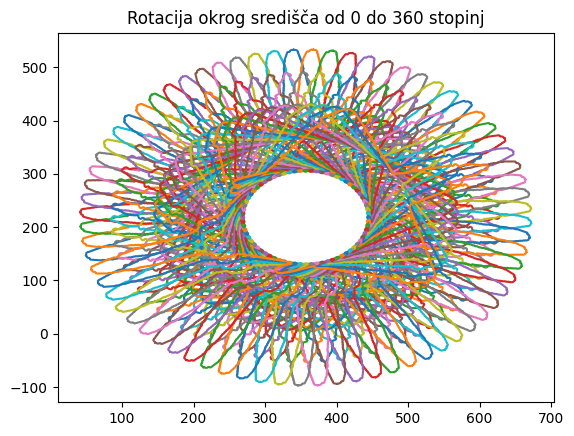

In [39]:
letala = np.load('data/letala.npy', allow_pickle=True)
letalo = letala[16]

center = np.mean(letalo, axis=0)

def rotation_matrix(angle):
    angle_rad = np.radians(angle)
    oMat = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                     [np.sin(angle_rad), np.cos(angle_rad)]])
    return oMat

plt.figure()
for fi in range(5, 361, 5):
    letaloR = np.dot(letalo - center, rotation_matrix(fi)) + center
    plt.plot(letaloR[:, 0], letaloR[:, 1])

plt.title('Rotacija okrog središča od 0 do 360 stopinj')
plt.show()

2. 2. Za vsak korak z metodo iterativno najbližje točke poravnajte rotirano obliko v nerotirano obliko (kot $0^{\circ}$).

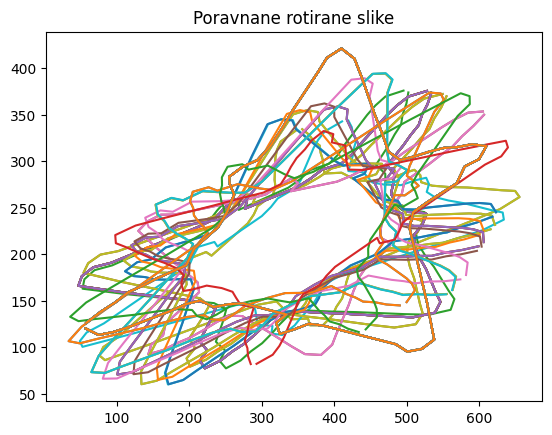

In [40]:
step = 20
iPtsRef = letalo[::step]
err = []

plt.figure()
for fi in range(5, 361, 5):
    letaloR = np.dot(letalo - center, rotation_matrix(fi)) + center
    iPtsMov = letaloR[::step]
    oMat2D_t, oErr = alignICP(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50, plotProgress=False)
    iPtsMov_t = np.dot(addHomCoord2D(iPtsMov), oMat2D_t.transpose())
    err.append(oErr[-1])
    plt.plot(iPtsMov_t[:, 0], iPtsMov_t[:, 1])

plt.title('Poravnane rotirane slike')
plt.show()

2. 3. Ali je poravnava uspešna za vse rotacije? Pokažite tako, da za vsak korak izračunate napako kot povprečno razdaljo med istoindeksiranimi točkami v referenčni in poravnani obliki. Napako prikažite na grafu v odvisnosti od kota rotacije.

Ne, poravnava ni uspešna za vse rotacije.


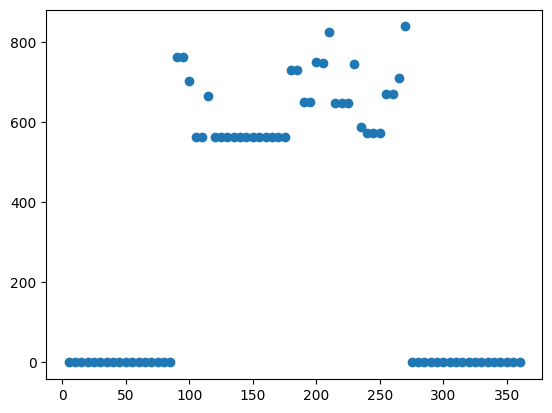

In [20]:
print('Ne, poravnava ni uspešna za vse rotacije.')

angles = list(range(5, 361, 5))
plt.figure()
plt.scatter(angles, err)
plt.show()

3. Napišite funkcijo, ki ustvari $4 \times 4$ matriko poljubne 3D afine preslikave:
```python
    def transAffine3D( iScale, iTrans, iRot, iShear ):
	  	return oMat3D
```
 kjer je `iScale` trivrstični vektor s parametri skale $k_x,\,k_y$ in $k_z$, `iTrans` trivrstični vektor s parametri translacije $t_x,\,t_y$ in $t_z$, `iRot` trivrstični vektor s koti rotacije $\alpha,\,\beta$ in $\gamma$ v stopinjah in `iShear` šestvrstični vektor s parametri striga $g_{xy},\,g_{xz},\,g_{yx},\,g_{zx},\,g_{zy},\,g_{yz}$. Funkcija vrne homogeno matriko `oMat3D`, ki ima dimenzije $4 \times 4$. Preverite delovanje funkcije na 3D oblikah v datoteki `data/glave.npy` tako, da točke izbrane oblike preslikate s poljubnimi parametri striga, rotacije, translacije in skaliranja, nato pa še s poljubno 3D afino preslikavo. Vhodne in preslikane točke oblike prikažite z dano funkcijo `renderSurface.py`.

 Izbrano obliko rotirajte za $180^{\circ}$ okrog svojega središča in okrog poljubne osi. Prikažite glavo pred in po poravnavi.
 
 Namig: Vseh pet 3D oblik naložite z ukazom `glave = numpy.load('data/glave.npy')`. 3D oblike so zapisane v seznamu tipa `list`, točke prve oblike dobite z ukazom `x = glave[0]` 

3. 1. Implementirajte funkcijo `transAffine3D`:

In [22]:
def transAffine3D(iScale=(1, 1, 1), iTrans=(0, 0, 0), iRot=(0, 0, 0), iShear=(0, 0, 0, 0, 0, 0)):
    oMatScale = np.array([[iScale[0],         0,         0, 0],
                          [        0, iScale[1],         0, 0],
                          [        0,         0, iScale[2], 0],
                          [        0,         0,         0, 1]])
    oMatTrans = np.array([[1, 0, 0, iTrans[0]],
                          [0, 1, 0, iTrans[1]],
                          [0, 0, 1, iTrans[2]],
                          [0, 0, 0,         1]])
    cA = np.cos(iRot[0])
    cB = np.cos(iRot[1])
    cG = np.cos(iRot[2])
    sA = np.sin(iRot[0])
    sB = np.sin(iRot[1])
    sG = np.sin(iRot[2])
    oMatRot = np.array([[ cB*cG, cA*sG+sA*sB*cG, sA*sG-cA*sB*cG, 0],
                        [-cB*sG, cA*cG-sA*sB*sG, sA*cG+cA*sB*sG, 0],
                        [    sB,         -sA*cB,          cA*cB, 0],
                        [     0,              0,              0, 1]])
    #iShear = (g_xy, g_xz, g_yx, g_yz, g_zx, g_zy)
    oMatShear = np.array([[        1, iShear[0], iShear[1], 0],
                          [iShear[2],         1, iShear[3], 0],
                          [iShear[4], iShear[5],         1, 0],
                          [        0,         0,         0, 1]])
    oMat3D = np.dot(oMatTrans, np.dot(oMatShear, np.dot(oMatRot, oMatScale)))
    return oMat3D

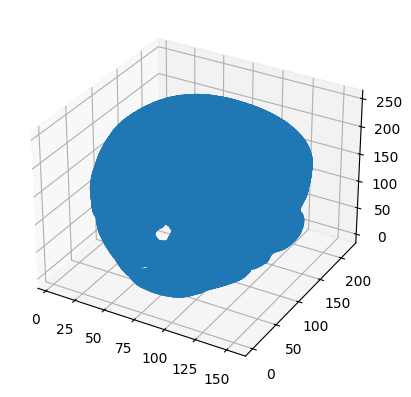

In [23]:
# Primer uporabe funkcije renderSurface

def showPointCloud(point_cloud, iTitle=''):
    # Extract x, y, and z coordinates from the glava variable
    x = point_cloud[:, 0]
    y = point_cloud[:, 1]
    z = point_cloud[:, 2]
    # Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    # Set labels and title
    #ax.set_xlabel('X')
    #ax.set_ylabel('Y')
    #ax.set_zlabel('Z')
    ax.set_title(iTitle)
    # Show the plot
    plt.show()

glave = np.load('data/glave.npy', allow_pickle=True)
glava = glave[0]
#renderSurface(glave[0][0], glave[0][1], glave[0][2])
showPointCloud(glava)

3. 2. Preverite delovanje funkcije na 3D oblikah v datoteki `data/glave.npy` tako, da točke izbrane oblike preslikate s poljubnimi parametri striga, rotacije, translacije in skaliranja, nato pa še s poljubno 3D afino preslikavo. Vhodne in preslikane točke oblike prikažite z dano funkcijo `renderSurface.py`.

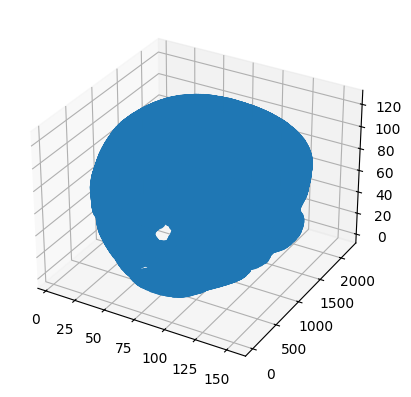

In [24]:
scaleM = transAffine3D(iScale=(1, 10, 0.5))
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])
glavaScale_h = np.dot(glava_h, scaleM.T)
glavaScale = glavaScale_h[:, :3] / glavaScale_h[:, 3, None]
showPointCloud(glavaScale)

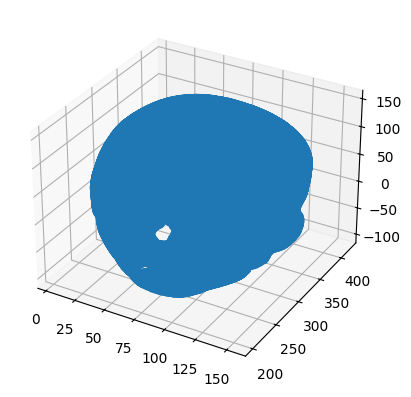

In [25]:
transM = transAffine3D(iTrans=(0, 200, -100))
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])
glavaTrans_h = np.dot(glava_h, transM.T)
glavaTrans = glavaTrans_h[:, :3] / glavaTrans_h[:, 3, None]
showPointCloud(glavaTrans)

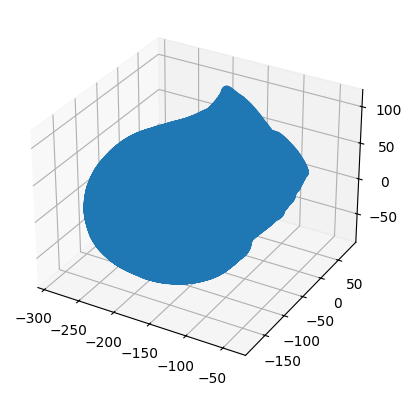

In [26]:
rotM = transAffine3D(iRot=(0, 90, -45))
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])
glavaRot_h = np.dot(glava_h, rotM.T)
glavaRot = glavaRot_h[:, :3] / glavaRot_h[:, 3, None]
showPointCloud(glavaRot)

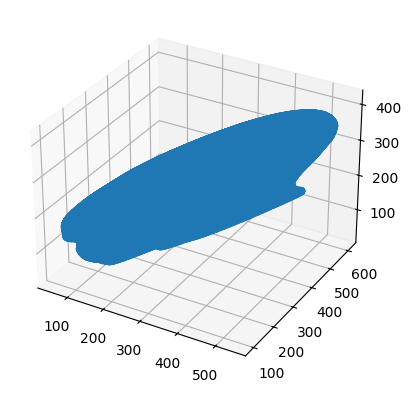

In [27]:
shearM = transAffine3D(iShear=(2, 0, 3, 0, 0, 1))
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])
glavaShear_h = np.dot(glava_h, shearM.T)
glavaShear = glavaShear_h[:, :3] / glavaShear_h[:, 3, None]
showPointCloud(glavaShear)

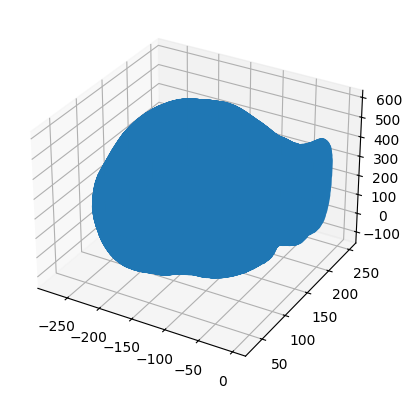

In [28]:
affineM = transAffine3D(iScale=(5, 1, 1), iTrans=(0, 30, -60), iRot=(0, 90, 0), iShear=(0, 0.5, 0, 0, 0, 0))
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])
glavaAffine_h = np.dot(glava_h, affineM.T)
glavaAffine = glavaAffine_h[:, :3] / glavaAffine_h[:, 3, None]
showPointCloud(glavaAffine)

3. 3. Izbrano obliko rotirajte za $180^{\circ}$ okrog svojega središča in okrog poljubne osi. Prikažite glavo pred in po poravnavi.

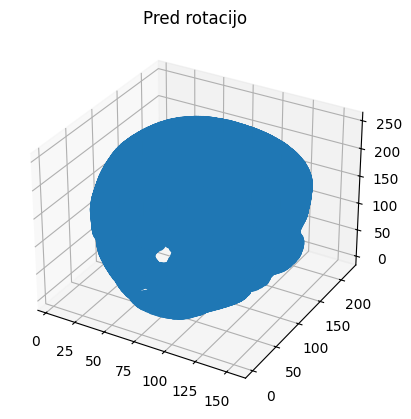

In [29]:
glave = np.load('data/glave.npy', allow_pickle=True)
glava = glave[0]
showPointCloud(glava, iTitle='Pred rotacijo')

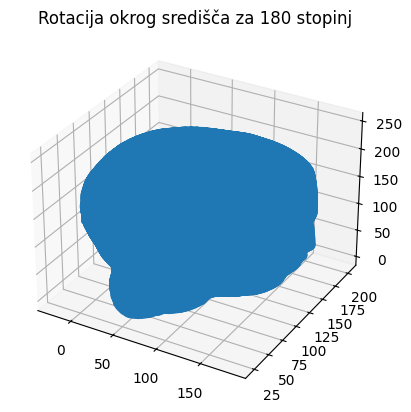

In [31]:
glave = np.load('data/glave.npy', allow_pickle=True)
glava = glave[0]
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])

center = np.mean(glava, axis=0)
mat = transAffine3D(iTrans=-center)
glava_2 = np.dot(glava_h, mat.T)
mat = transAffine3D(iRot=(0, 0, 180))
glava_2 = np.dot(glava_2, mat.T)
mat = transAffine3D(iTrans=center)
glava_2 = np.dot(glava_2, mat.T)

glava_2 = glava_2[:, :3] / glava_2[:, 3, None]

showPointCloud(glava_2, iTitle='Rotacija okrog središča za 180 stopinj')

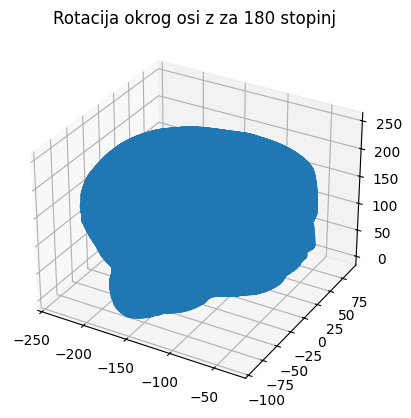

In [33]:
glave = np.load('data/glave.npy', allow_pickle=True)
glava = glave[0]
glava_h = np.hstack([glava, np.ones((glava.shape[0], 1))])

mat = transAffine3D(iRot=(0, 0, 180))
glava_3 = np.dot(glava_h, mat.T)

glava_3 = glava_3[:, :3] / glava_3[:, 3, None]

showPointCloud(glava_3, 'Rotacija okrog osi z za 180 stopinj')

4. 1. Napišite funkcijo za poravnavo dveh 3D oblik z metodo iterativno najbližje točke (ICP):
```python
    def alignICP3D( iPtsRef, iPtsMov, iEps, iMaxIter ):
        return oMat3D, oErr
```
kjer sta `iPtsRef` in `iPtsMov` matriki s koordinatami referenčnih in premičnih točk. Matriki imata dimenziji $K_R \times 3$ in $K_M \times 3$. `iEps` in `iMaxIter` določata pogoje za zaustavitev postopka, kjer je `iEps` najmanjša sprememba parametrov preslikave, `iMaxIter` pa maksimalno število korakov $k_{max}$. V funkciji uporabite 3D afino aproksimacijsko poravnavo, funkcija pa naj vrne optimalno 3D afino preslikavo med referenčnimi in premičnimi točkami v obliki homogene matrike `oMat3D` in vektor `oErr`, ki podaja napako $\Sigma^2$ med korespondenčnimi točkami v vsakem koraku metode ICP. 

In [34]:
def addHomCoord3D(iPts):
    # Check if points already have homogeneous coordinates
    if iPts.shape[-1] == 3:
        # Append a column of ones to make them homogeneous
        iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def mapAffineApprox3D(iPtsRef, iPtsMov): # referencne = U
    """Afina aproksimacijska poravnava"""
    # U = TX
    # UX'(XX')^(-1) = T
    iPtsRef = np.matrix(iPtsRef) # U
    iPtsMov = np.matrix(iPtsMov) # X
    # po potrebi dodaj homogeno koordinato
    iPtsRef = addHomCoord3D(iPtsRef)
    iPtsMov = addHomCoord3D(iPtsMov)
    #afina aproksimacia (s psevdoinvrzom XX')
    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()
    #psevdoinverz
    oMat3D = np.dot(iPtsRef, np.linalg.pinv(iPtsMov))
    #oMat2D = iPtsRef*iPtsMov.transpose() * np.linalg.inv(iPts......)
    # Lahko uporabljamo *, ker imamo matrike. Če bi imeli array bi morali uporabljati np.dot
    return oMat3D

def findCorrespondingPoints(iPtsRef, iPtsMov):
    """Poisci korespondence kot najblizje tocke"""
    # inicializiraj polje indeksov
    iPtsMov = np.array(iPtsMov)
    iPtsRef = np.array(iPtsRef)
    idxPair = -np.ones((iPtsRef.shape[0], 1), dtype='int32')
    idxDist = np.ones((iPtsRef.shape[0], iPtsMov.shape[0])) # za shranjevanje razdalij

    #print('shape:', iPtsRef.shape, idxDist.shape)
    #print(iPtsRef)
    #print(len(iPtsRef))
    
    for i in range(iPtsRef.shape[0]):
        for j in range(iPtsMov.shape[0]):
            idxDist[i, j] = np.sum((iPtsRef[i, :2] - iPtsMov[j, :2])**2)
    # doloci bijektivno preslikavo
    while not np.all(idxDist == np.inf):
        i, j = np.where(idxDist == np.min(idxDist))
        idxPair[i[0]] = j[0]
        idxDist[i[0], :] = np.inf # nasli smo match in smo dali vse ostale pare, ki vsebuje eno od teh tock na Inf
        idxDist[:, j[0]] = np.inf
    # doloci pare tock
    idxValid, idxNotValid = np.where(idxPair >= 0)
    idxValid = np.array(idxValid)
    iPtsRef_t = iPtsRef[idxValid, :]
    iPtsMov_t = iPtsMov[idxPair[idxValid].flatten(), :]
    return iPtsRef_t, iPtsMov_t

def alignICP3D(iPtsRef, iPtsMov, iEps=1e-6, iMaxIter=50):
    curMat = [] # seznam za shranjevanje matrik na vsakem koraku
    oErr = []
    iCurIter = 0

    while True:
        #poisci korespondencn tocke
        iPtsRef_t, iPtsMov_t = findCorrespondingPoints(iPtsRef, iPtsMov)
        #doloci afino aproskimacijsko preslkavo 
        oMat3D = mapAffineApprox3D(iPtsRef_t, iPtsMov_t)
        #pososdobi posamezne tocke
        iPtsMov = np.dot(addHomCoord3D(iPtsMov), oMat3D.transpose())
        # izracunaj napako
        curMat.append(oMat3D)
        #print(':)', curMat[0].shape, oMat3D.shape)
        oErr.append(np.sqrt(np.sum((iPtsRef_t[:, :3] - iPtsMov_t[:, :3])**2)))
        iCurIter +=1
        # preveri kontroln parametre
        dMat = np.abs(oMat3D - transAffine3D())
        if iCurIter > iMaxIter or np.all(dMat < iEps):
            break
    
    oMat3D = transAffine3D()
    for i in range(len(curMat)):
        oMat3D = np.dot(curMat[i], oMat3D)

    return oMat3D, oErr

4. 2. Preverite pravilnost delovanja funkcije tako, da vse točke izbrane oblike preslikate s poljubnimi parametri 3D afine preslikave in preverite ali funkcija vrne preslikavo v `oMat3D`, ki je podobna dani vaši 3D afini preslikavi in da je končna napaka `oErr` manjša od začetne napake in približno enaka 0. Naložite referenčne in premične točke dveh poljubnih, a različnih oblik iz dane zbirke glav in preverite, da funkcija obliki ustrezno poravna.

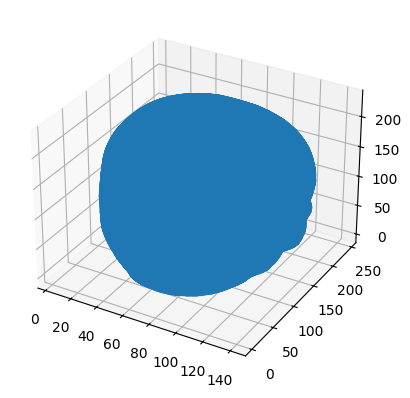

In [35]:
step = 500
oMat3D, oErr = alignICP3D(glave[0][::step], glave[1][::step], iMaxIter=4)
showPointCloud(glave[1])

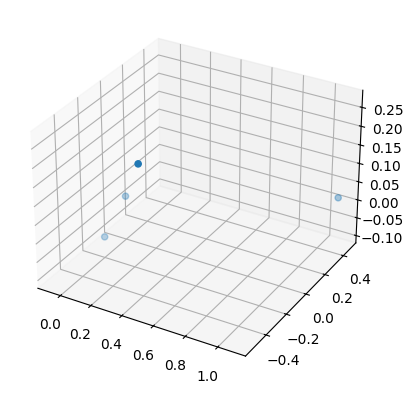

In [36]:
showPointCloud(oMat3D)

4. 3. Izvedite poravnavo vseh 3D oblik `[1, 4]` na obliko z indeksom 0. Izpišite najmanjšo in največjo vrednost napake `oErr` pred poravnavno in po njej.

In [37]:
glave = np.load('data/glave.npy', allow_pickle=True)
glava_ref = glave[0]
step = 500

err_1 = []
err_2 = []

for i in range(4):
    glava_mov = glave[i+1]
    oMat3D, oErr = alignICP3D(glava_ref[::step], glava_mov[::step], iMaxIter=4)
    err_1.append(oErr[0])
    err_2.append(oErr[-1])

print('najmanjša napaka pred poravnavo:', np.min(err_1))
print('največja napaka pred poravnavo:', np.max(err_1))
print('najmanjša napaka po poravnavi:', np.min(err_2))
print('največja napaka po poravnavi:', np.max(err_2))

najmanjša napaka pred poravnavo: 162.5146147274146
največja napaka pred poravnavo: 2009.4026475547403
najmanjša napaka po poravnavi: 1110.8319187941709
največja napaka po poravnavi: 1192.4312385578914
